In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    #ipdb.set_trace()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan
    ds['intercept'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box
    perPixel = False
    if bsingle:
        bb = b
    elif c_box:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])
    else:
        perPixel=True


    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            elif c_box:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)
            elif perPixel:
                bb = b.sel(latitude=lat, longitude=lon)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

#                 if (np.nansum(aa.values == 0) >= 10):
#                     p = np.nan
#                     r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [4]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [5]:
    def array_juggling(data, month, hour=None):

        m = month

        if hour is not None:
            if len(month) > 1:

                data = data[((data['time.month'] >= month[0]) | (data['time.month'] <= month[1])) & (
                            data['time.hour'] == hour) & (data['time.year'] >= 1983) & (data['time.year'] <= 2018)]
            else:

                data = data[
                    (data['time.month'] == month[0]) & (data['time.hour'] == hour) & (data['time.year'] >= 1983) & (
                                data['time.year'] <= 2018)]
        else:
            if len(month) > 1:
                data = data[((data['time.month'] >= month[0]) | (data['time.month'] <= month[1])) & (
                            data['time.year'] >= 1983) & (data['time.year'] <= 2018)]
            else:
                data = data[
                    (data['time.month'] == month[0]) & (data['time.year'] >= 1983) & (data['time.year'] <= 2018)]

        data_years = data.groupby('time.year').mean(axis=0)

        data_mean = data.mean(axis=0)

        # diff = xr.DataArray(data_years.values[1::, :, :] - data_years.values[0:-1, :, :],
        #                     coords=[data_years.year[1::], data.latitude, data.longitude], dims=['year','latitude', 'longitude'] )
        diff = xr.DataArray(data_years.values, coords=[data_years.year, data.latitude, data.longitude],
                            dims=['year', 'latitude', 'longitude'])
        # unstack back to lat lon coordinates
        return diff, data_mean


In [6]:
date = '2016-01-13'
dt = pd.to_datetime(date)

In [7]:
u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')
# u200orig = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/uv_15UTC/*.nc')
# u200orig = u200orig['u'].sel(level=250).load()
# u200orig.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')

In [8]:
datetimes = pd.to_datetime(u200orig.time.values)

In [9]:
newtimes = []
for t in datetimes:
     newtimes.append(t.replace(hour=0))

In [10]:
u200orig['time'] = ('time', newtimes)

In [11]:
u200orig

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -24.5 -24.75 -25.0
    level      int32 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 ...

In [12]:
chirpsbox = [-81,-68,-17,0]
u200 = u200orig.sel(longitude=slice(chirpsbox[0], chirpsbox[1]), latitude=slice(chirpsbox[3], chirpsbox[2]))
u200orig = u200orig.sel(time=(u200orig['time.year']>1984))

In [13]:
chirps_all = xr.open_dataset('/media/ck/Elements/SouthAmerica/CHIRPS/CHIRPS_peru_onERA5.nc')

In [14]:
gridsat_small = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_ALLkm2_UTC_DAY_onERA/*.nc', combine='nested', concat_dim='time')
gridsat_small = gridsat_small.sel(longitude=slice(chirpsbox[0], chirpsbox[1]), latitude=slice(chirpsbox[2], chirpsbox[3])).load()

In [15]:
gridsat = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_ALLkm2_UTC_DAY_onBIGERA/*.nc', combine='nested', concat_dim='time').load()

In [17]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-83,-55), lat=slice(-26,7))

In [20]:
gridsat

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12906)
Coordinates:
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2019-09-30
Data variables:
    tir        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [19]:
topo

<xarray.DataArray 'h' (lat: 2280, lon: 2580)>
[5882400 values with dtype=int16]
Coordinates:
  * lon      (lon) float32 -82.99167 -82.975 -82.958336 ... -40.02501 -40.00833
  * lat      (lat) float32 -29.991665 -29.974998 ... 7.9749985 7.991661
Attributes:
    long_name:  Altitude
    units:      m

In [21]:
pos = np.intersect1d(chirps_all.time, u200.time)

In [22]:
posgrid =  np.intersect1d(u200orig.time.values,gridsat.time.values)

In [23]:
gcpos =  np.intersect1d(chirps_all.time.values,gridsat_small.time.values)

In [24]:
chirps = chirps_all.sel(time=pos)

In [25]:
u200orig = u200orig.sel(time=posgrid)

In [26]:
gridsat = gridsat.sel(time=posgrid)

In [27]:
gc_g = gridsat_small.sel(time=gcpos)
gc_c = chirps_all.sel(time=gcpos)

In [28]:
topo_on_g = gc_g.salem.lookup_transform(topo)

In [37]:
for ids in range(len(gc_g.time)):
    gc_g['tir'][ids].values[topo_on_g<1000]=np.nan
    gc_c['precip'][ids].values[topo_on_g<1000]=np.nan

KeyboardInterrupt: 

In [36]:
gc_g['tir'][0]

<xarray.DataArray 'tir' (latitude: 69, longitude: 53)>
array([[           nan,            nan,            nan, ...,
            0.        ,     0.        , -2372.11111111],
       [           nan,            nan,            nan, ...,
         -337.16666667,     0.        ,     0.        ],
       [           nan,            nan,            nan, ...,
         -369.58333333,  -536.1875    ,     0.        ],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * latitude   (latitude) float32 -17.0 -16.75 -16.5 -16.25 ... -0.5 -0.25 0.0
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -68.5 -68.25 -68.0
    time       datetime64[ns] 1984-01-01
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [33]:
plt.scatter(gc_g['tir'].values[topo.values>1000], gc_c['precip'].values[topo.values>1000])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12604 but corresponding boolean dimension is 2280

In [25]:
u200orig

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12389)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -24.5 -24.75 -25.0
    level      int32 ...
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 ...

In [26]:
cdoy = chirps.rolling(time=3, min_periods=1, center=True).mean(dim='time')
udoy = u200.rolling(time=3, min_periods=1, center=True).mean(dim='time')
ugdoy = u200orig.rolling(time=3, min_periods=1, center=True).mean(dim='time')
gdoy = gridsat.rolling(time=3, min_periods=1, center=True).mean(dim='time')

In [29]:
ugdoy

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12389)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -24.5 -24.75 -25.0
    level      int32 250
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 7.766353 ... 1.4854531

In [30]:
gdoy

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12389)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
Data variables:
    tir        (time, latitude, longitude) float64 0.0 0.0 ... 0.0 -4.547e-13

In [442]:
udoy.sel(time=(udoy['time.dayofyear']==d))

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 53, time: 38)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -68.5 -68.25 -68.0
  * latitude   (latitude) float32 -17.0 -16.75 -16.5 -16.25 ... -0.5 -0.25 0.0
    level      int32 200
  * time       (time) datetime64[ns] 1981-04-05 1982-04-05 ... 2018-04-05
Data variables:
    u          (time, latitude, longitude) float32 10.552475 ... -9.93823

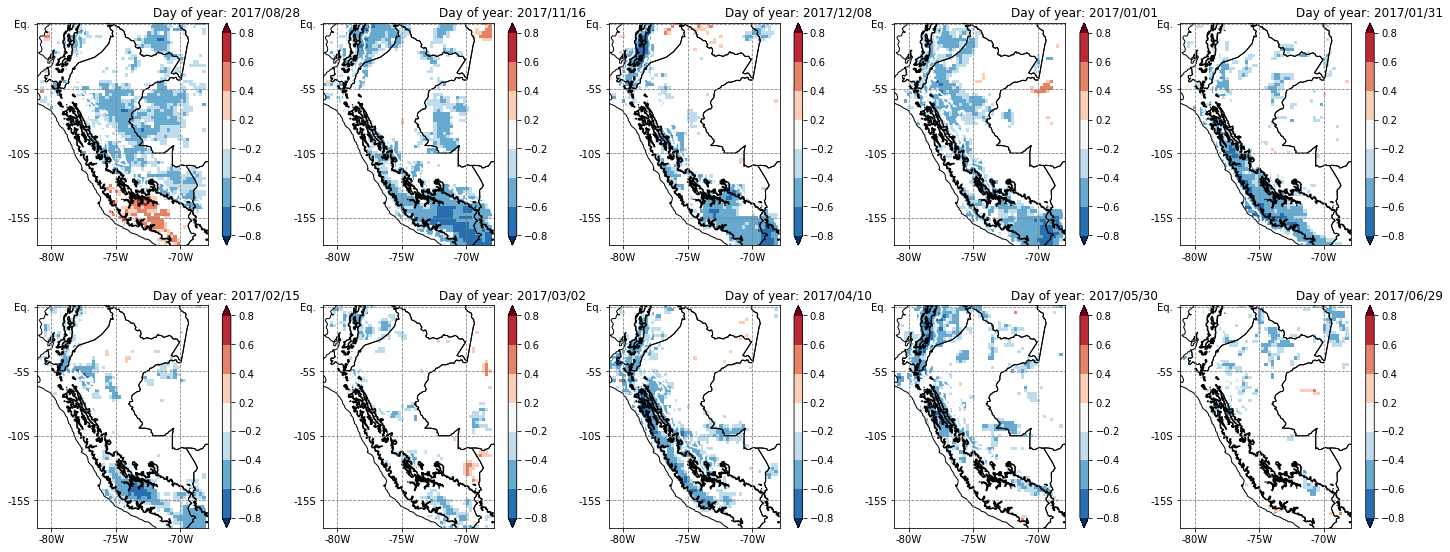

In [456]:
map = cdoy.salem.get_map()
f = plt.figure(figsize=(20,8))
for ids, d in enumerate([240,320,342,1,31,46,61,100,150,180]):
    ccdoy = cdoy['precip'].sel(time=(cdoy['time.dayofyear']==d))
    uudoy = udoy['u'].sel(time=(udoy['time.dayofyear']==d))
    
    diff1 = xr.DataArray(ccdoy.values[1::, :, :] - ccdoy.values[0:-1, :, :],
                 coords=[ccdoy.time[1::], ccdoy.latitude, ccdoy.longitude], dims=['time','latitude', 'longitude'] )
    diff2 = xr.DataArray(uudoy.values[1::, :, :] - uudoy.values[0:-1, :, :],
                 coords=[uudoy.time[1::], uudoy.latitude, uudoy.longitude], dims=['time','latitude', 'longitude'] )
    
    outarr = corr(diff1, diff2)
    
    date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(d - 1)+' days')
    dstr = date.strftime("%Y/%m/%d")
    
    ax = f.add_subplot(2,5,ids+1)
    oarr = outarr['r'].where(outarr['pval']<=0.05)
    map.set_data(oarr)
    map.set_plot_params(levels=[-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8], cmap='RdBu_r', extend='both')
    map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
    map.visualize()

    plt.plot(-77.5, -9.5, 'ro')
    plt.title('Day of year: '+str(dstr))
plt.tight_layout()

/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common

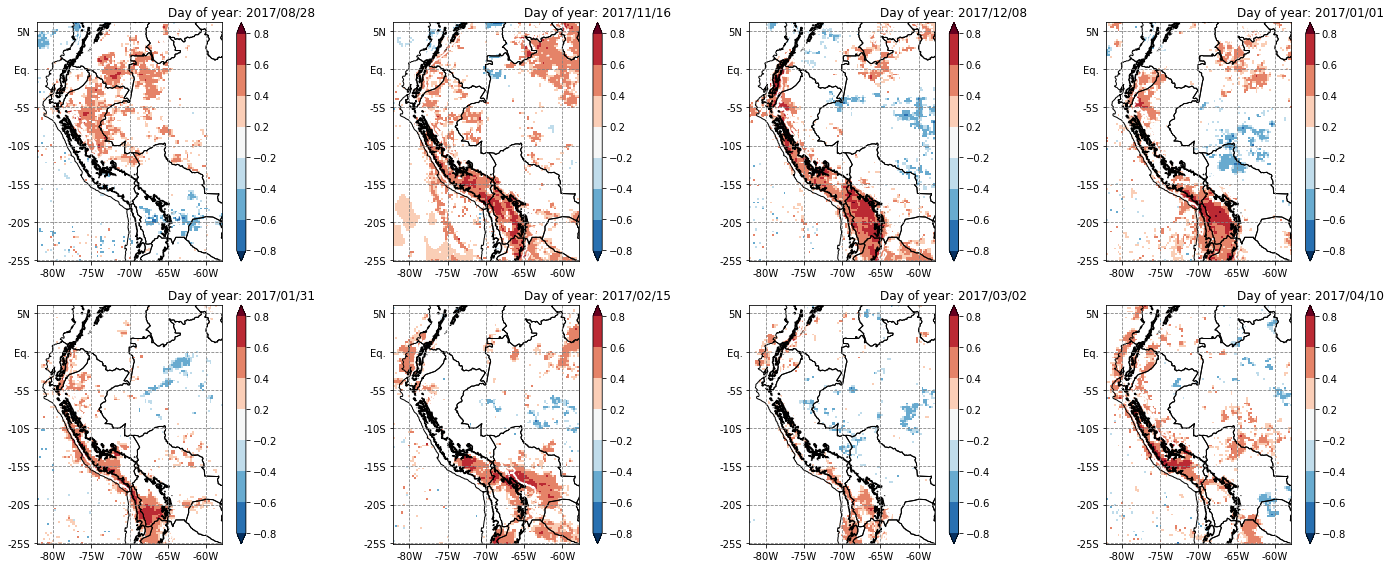

In [32]:
map = gdoy.salem.get_map()
f = plt.figure(figsize=(20,8))
for ids, d in enumerate([240,320,342,1,31,46,61,100]):
    ggdoy = gdoy['tir'].sel(time=(gdoy['time.dayofyear']==d))
    uudoy = ugdoy['u'].sel(time=(ugdoy['time.dayofyear']==d))
    
    diff1 = xr.DataArray(ggdoy.values[1::, :, :] - ggdoy.values[0:-1, :, :],
                 coords=[ggdoy.time[1::], ggdoy.latitude, ggdoy.longitude], dims=['time','latitude', 'longitude'] )
    diff2 = xr.DataArray(uudoy.values[1::, :, :] - uudoy.values[0:-1, :, :],
                 coords=[uudoy.time[1::], uudoy.latitude, uudoy.longitude], dims=['time','latitude', 'longitude'] )
    
    outarr = corr(diff1, diff2)
    
    date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(d - 1)+' days')
    dstr = date.strftime("%Y/%m/%d")
    
    

    
    ax = f.add_subplot(2,4,ids+1)
    oarr = outarr['r'].where(outarr['pval']<=0.01)
    map.set_data(oarr)
    map.set_plot_params(levels=[-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8], cmap='RdBu_r', extend='both')
    map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
    map.visualize()

    plt.plot(-77.5, -9.5, 'ro')
    plt.title('Day of year: '+str(dstr))
plt.tight_layout()